# Implementing Hyperbolic K-Means
`Drew Wilimitis`

In this notebook, I attempt to extend the idea of Poincaré embeddings and hyperbolic multidimensional scaling by exploiting the representational capacity of these embeddings to apply clustering in hyperbolic space. Given that K-means is a relatively simpler clustering algorithm with existing implementations in the standard Euclidean space, I test an implementation of K-means clustering in  hyperbolic space. <br>
<br>
My hypothesis is that given the demonstrated success of hyperbolic embeddings in learning hierarchical relationships, applying hyperbolic clustering algorithms to hyperbolically embedded data may outperform clustering in euclidean space, specifically on hierarchical datasets.

## Algorithm Outline

Given data in the Poincare disk $x_1, \ldots , x_N \in \mathcal{B}^{d}$, partition the $N$ observations into k sets denoted by $\mathbf{S}=\left\{S_{1}, S_{2}, \ldots, S_{k}\right\}$, where we have $k$ centroids or means $\left\{\boldsymbol{m}_{i}^{(t)}\right\}_{i=1}^{k}$ at each iteration $t$. <br>
<br>
The basic steps in Hyperbolic k-means are: <br>
1. **Initialization step**: initialize k random centroids $\left\{\boldsymbol{m}_{i}^{(t)}\right\}_{i=1}^{k} \in \mathcal{B}^{d}$<br>
2. **Assignment step**: assign each $x_p$ to nearest centroid with smallest poincare distance<br>
3. **Project to H**: project to hyperboloid model<br>
4. **Update step**: calculate new means with optimization in Hyperboloid model <br>
5. **Project back to Poincare disk**: map back into poincare disk model
6. **Repeat steps 2-5 until stopping criteria** <br>
7. **Return:** cluster labels for all $x_i$ and cluster means $\left\{\boldsymbol{m}_{i}\right\}_{i=1}^{k}$

## Load libraries and helper functions

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from sklearn.utils import check_random_state

# ignore warnings
import warnings
warnings.filterwarnings('ignore');

# display multiple outputs within a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all";

def norm(x, axis=None):
    return np.linalg.norm(x, axis=axis)

## Poincaré Disk vs. Hyperboloid Model

In [163]:
eps = 1e-6

# distance in poincare disk
def poincare_dist(u, v, eps=1e-5):
    d = 1 + 2 * norm(u-v)**2 / ((1 - norm(u)**2) * (1 - norm(v)**2) + eps)
    return np.arccosh(d)

# compute symmetric poincare distance matrix
def poincare_distances(embedding):
    n = embedding.shape[0]
    dist_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(i+1, n):
            dist_matrix[i][j] = poincare_dist(embedding[i], embedding[j])
    return dist_matrix

# convert array from poincare disk to hyperboloid
def poincare_pts_to_hyperboloid(Y):
    mink_pts = np.zeros((Y.shape[0], Y.shape[1]+1))
    r = norm(Y, axis=1)
    mink_pts[:, 0] = 2/(1 - r**2 + eps) * Y[:, 0]
    mink_pts[:, 1] = 2/(1 - r**2 + eps) * Y[:, 1]
    mink_pts[:, 2] = 2/(1 - r**2 + eps) * (1 + r**2)/2
    return mink_pts

# convert single point to hyperboloid
def poincare_pt_to_hyperboloid(y):
    mink_pt = np.zeros((3, ))
    r = norm(y)
    mink_pt[0] = 2/(1 - r**2 + eps) * y[0]
    mink_pt[1] = 2/(1 - r**2 + eps) * y[1]
    mink_pt[2] = 2/(1 - r**2 + eps) * (1 + r**2)/2
    return mink_pt

In [164]:
# define hyperboloid bilinear form
def hyperboloid_dot(u, v):
    return np.dot(u[:-1], v[:-1]) - u[-1]*v[-1]

# hyperboloid distance function
def hyperboloid_dist(u, v):
    dist = np.arccosh(-1*hyperboloid_dot(u, v))
    if np.isnan(dist):
        #print('Hyperboloid dist returned nan value')
        return eps
    else:
        return dist

# compute symmetric hyperboloid distance matrix
def hyperboloid_distances(embedding):
    n = embedding.shape[0]
    dist_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(i+1, n):
            dist_matrix[i][j] = hyperboloid_dist(embedding[i], embedding[j])
    return dist_matrix

# convert array to poincare disk
def hyperboloid_pts_to_poincare(X):
    poincare_pts = np.zeros((X.shape[0], X.shape[1]-1))
    poincare_pts[:, 0] = X[:, 0] / ((X[:, 2]+1) + eps)
    poincare_pts[:, 1] = X[:, 1] / ((X[:, 2]+1) + eps)
    return poincare_pts

def proj(theta,eps=1e-3):
    if norm(theta) >= 1:
        theta = theta/norm(theta) - eps
    return theta

# convert single point to poincare
def hyperboloid_pt_to_poincare(x):
    poincare_pt = np.zeros((2, ))
    poincare_pt[0] = x[0] / ((x[2]+1) + eps)
    poincare_pt[1] = x[1] / ((x[2]+1) + eps)
    return proj(poincare_pt)

In [165]:
# helper function to generate samples
def generate_data(n, radius=0.7, hyper=False):
    theta = np.random.uniform(0, 2*np.pi, n)
    u = np.random.uniform(0, radius, n)
    r = np.sqrt(u)
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    init_data = np.hstack((x.reshape(-1,1), y.reshape(-1,1)))
    if hyper:
        return poincare_pts_to_hyperboloid(init_data)
    else:
        return init_data

In [166]:
# test hyperboloid bilinear form condition
data = generate_data(20)
poinc_pts = data
mink_pts = poincare_pts_to_hyperboloid(data)
np.array([np.allclose(hyperboloid_dot(pt, pt), -1) for pt in mink_pts]).all()

# test poincare -> hyperboloid are inverses
mink_pts = poincare_pts_to_hyperboloid(data)
poinc_pts = hyperboloid_pts_to_poincare(mink_pts)
if np.allclose(data, poinc_pts):
    print('Inverse test passed!')

True

Inverse test passed!


# Frechet Mean Optimization in Hyperboloid Model

In [167]:
def exp_map(v, theta):
    # v: tangent vector in minkowski space
    # theta: parameter vector in hyperboloid with centroid coordinates
    # project vector v from tangent minkowski space -> hyperboloid
    return np.cosh(norm(v))*theta + np.sinh(norm(v)) * v / (norm(v) + eps)

def minkowski_distance_gradient(u, v):
    # u,v in hyperboloid
    # returns gradient with respect to u
    return -1*(hyperboloid_dot(u,v)**2 - 1)**-1/2 * v

def minkowski_loss_gradient(theta, X):
    # X : array with points in hyperboloid cluster
    # theta: parameter vector in hyperboloid with centroid coordinates
    # returns gradient vector
    distances = np.array([-1*hyperboloid_dist(theta, x) for x in X]).reshape(-1,1)
    distance_grads = np.array([minkowski_distance_gradient(theta, x) for x in X])
    grad_loss = 2*np.mean(distances*distance_grads, axis=0)
    if np.isnan(grad_loss).any():
        print('Hyperboloid dist returned nan value')
        return eps
    else:
        return grad_loss

def project_to_tangent(theta, minkowski_grad):
    # grad: gradient vector in ambient Minkowski space
    # theta: parameter vector in hyperboloid with centroid coordinates
    # projects to hyperboloid gradient in tangent space
    return minkowski_grad + hyperboloid_dot(theta, minkowski_grad)*theta

def update_theta(theta, hyperboloid_grad, alpha=0.1):
    # theta: parameter vector in hyperboloid with centroid coordinates
    return exp_map(-1*alpha*hyperboloid_grad, theta)

In [168]:
def frechet_loss(theta, X):
    s = X.shape[0]
    dist_sq = np.array([hyperboloid_dist(theta, x)**2 for x in X])
    return np.sum(dist_sq) / s

def frechet_mean(theta, X, num_rounds = 10, alpha=0.3, tol = 1e-4, verbose=False):
    centr_pt = theta.copy()
    centr_pts = []
    losses = []
    for i in range(num_rounds):
        gradient_loss = minkowski_loss_gradient(centr_pt, X)
        tangent_v = project_to_tangent(centr_pt, -gradient_loss)
        centr_pt = update_theta(centr_pt, tangent_v, alpha=alpha)
        centr_pts.append(centr_pt)
        losses.append(frechet_loss(centr_pt, X))
        if verbose:
            print('Epoch ' + str(i+1) + ' complete')
            print('Loss: ', frechet_loss(centr_pt, X))
            print('\n')
    return centr_pt

## Poincaré KMeans

In [194]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
class PoincareKMeans():
    """
    Perform K-Means clustering in hyperbolic space. Applies gradient descent in
    the hyperboloid model to iteratively compute Fréchet means, and the Poincaré disk
    model for visualization.
    
    API design is modeled on the standard scikit-learn Classifier API
    """
    
    def __init__(self,n_clusters=8,n_init=20,max_iter=300,tol=1e-8,verbose=False):
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.max_iter = max_iter
        self.tol = tol
        self.verbose =  verbose
        self.labels = None
        self.cluster_centers_ = None
        
    def init_centroids(self, radius=0.3):
        # randomly sample starting points on small uniform ball
        theta = np.random.uniform(0, 2*np.pi, self.n_clusters)
        u = np.random.uniform(0, radius, self.n_clusters)
        r = np.sqrt(u)
        x = r * np.cos(theta)
        y = r * np.sin(theta)
        centers = np.hstack((x.reshape(-1,1), y.reshape(-1,1)))
        self.centroids = centers
        
    def init_assign(self):
        # cluster assignments as indicator matrix
        assignments = np.zeros((self.n_samples, self.n_clusters))
        for i in range(self.n_samples):
            # randomly initialize each binary vector
            j = np.random.randint(0, self.n_clusters)
            assignments[i][j] = 1
        self.assignments = assignments
        
    def update_centroids(self, X):
        """Updates centroids with Fréchet means in Hyperboloid model
        Parameters
        ----------
        X : array of shape (n_samples, dim) with input data.
        First convert X to hyperboloid points
        """
        dim = X.shape[1]
        new_centroids = np.empty((self.n_clusters, dim)) 
        H = poincare_pts_to_hyperboloid(X)
        for i in range(self.n_clusters):
            if np.sum(self.assignments[:, i] ==1) == 0:
                new_centroids[i] = self.centroids[i]
            else:
                # find subset of observations in cluster
                H_k = H[self.assignments[:, i] ==1]
                theta_k = poincare_pt_to_hyperboloid(self.centroids[i])
                # solve for frechet mean
                fmean_k = frechet_mean(theta_k, H_k, alpha=0.1)
                # convert back to Poincare disk
                new_centroids[i] = hyperboloid_pt_to_poincare(fmean_k)
        self.centroids = new_centroids
        
    def cluster_var(self, X):
        n = self.centroids.shape[0]
        var_C = []
        for i in range(n):
            var_C.append(np.mean(np.array([poincare_dist(self.centroids[i], x) for x in X])))
        self.variances = np.sort(var_C)[-2]
    
    def fit(self, X, init=None):
        """
        Uses gradient descent to find the embedding configuration in the Poincaré disk
        Parameters
        ----------
        X : array, shape (n_samples, n_features) or (n_samples, n_samples)
            Input data. If ``dissimilarity=='precomputed'``, the input should
            be the dissimilarity matrix.
        init: initial configuration of the embedding coordinates
        """
        self.fit_transform(X, init=init)
        return self

    def fit_predict(self, X, max_epochs=40, verbose=False):
        """
        Fit the embedding from X, and return the embedding coordinates
        Parameters
        ----------
        X : array, shape (n_samples, n_features) or (n_samples, n_samples)
            Input data. If ``dissimilarity=='precomputed'``, the input should
            be the dissimilarity matrix.
        max_epochs: maximum number of gradient descent iterations
        verbose: optionally print training scores
        """
        
        # make sure X within poincaré ball
        #X = Normalizer().fit_transform(X)
        if (norm(X, axis=1) > 1).any():
            X = X / (np.max(norm(X, axis=1)))
        
        # initialize random centroids and assignments
        self.n_samples = X.shape[0]
        self.init_centroids()
        self.init_assign()
        
        # loop through the assignment and update steps
        for j in range(max_epochs):
            self.inertia_ = 0
            self.update_centroids(X)
            for i in range(self.n_samples):
                # zero out current cluster assignment
                self.assignments[i, :] = np.zeros((1, self.n_clusters))
                # find closest centroid (in Poincare disk)
                centroid_distances = np.array([poincare_dist(X[i], centroid) for centroid in self.centroids])
                cx = np.argmin(centroid_distances)
                self.inertia_ += centroid_distances[cx]**2
                self.assignments[i][cx] = 1
            if verbose:
                print('Epoch ' + str(j) + ' complete')
                print(self.centroids)
        self.labels = np.argmax(self.assignments, axis=1)
        self.cluster_var(X)
        return self.assignments

# Unsupervised Examples

In [195]:
def cluster_var(X, C):
    n = C.shape[0]
    var_C = []
    for i in range(n):
        var_C.append(np.mean(np.array([poincare_dist(C[i], x) for x in X])))
    return np.sort(var_C)[-2]

from sklearn.metrics.pairwise import pairwise_distances_argmin, pairwise_distances_argmin_min
def euclidean_inertia(X, centers):
    return np.sum(pairwise_distances_argmin_min(X, centers)[1]**2)

In [566]:
def plot_poincare(data, y, centroids, n_clusters, height=5, width=12, euclidean=False):
    plt.figure(figsize=(12,5))
    plt.subplot(121)
    plt.scatter(data[:, 0], data[:, 1], c='black')
    plt.subplot(122)
    #plt.xlim([-1.0,1.0])
    #plt.ylim([-1.0,1.0])
    colors = ['b', 'r', 'g', 'y', 'm', 'c', 'k', 'w']
    for i in range(n_clusters):
        if euclidean:
            plt.scatter(data[(y == i), 0], data[(y == i), 1], c = colors[i], 
                    alpha=0.8, edgecolors='w', linewidth=2)
            plt.scatter(centroids[i, 0], centroids[i, 1], s=100, c = colors[i], 
                        edgecolor='black', linewidth=2);
            plt.suptitle('Euclidean K-Means Clustering vs. Original Data', size=14);
        else:
            plt.scatter(data[(y[:, i] == 1), 0], data[(y[:, i] == 1), 1], c = colors[i],
                        alpha=0.8, edgecolors='w', linewidth=2)
            plt.scatter(centroids[i, 0], centroids[i, 1], s=100, c = colors[i],
                        edgecolor='black', linewidth=2);
            plt.suptitle('Poincaré K-Means Clustering vs. Original Data', size=14);
    plt.show();

## make_blobs data

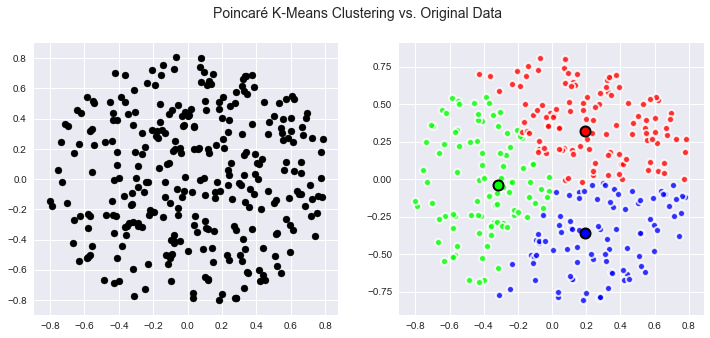

Cluster variance:  1.4897228691157194
Inertia (poincaré dist):  323.61211103142546
Inertia (euclidean dist):  41.088540638144856


In [565]:
plt.style.use('seaborn')
data = generate_data(300, radius=0.7)
pkmeans = PoincareKMeans(n_clusters=3)
plabels = pkmeans.fit_predict(data, max_epochs=5)
centroids = pkmeans.centroids
plot_poincare(data, plabels, centroids, 3)
print('Cluster variance: ', pkmeans.variances)
print('Inertia (poincaré dist): ', pkmeans.inertia_)
print('Inertia (euclidean dist): ', euclidean_inertia(data, centroids))

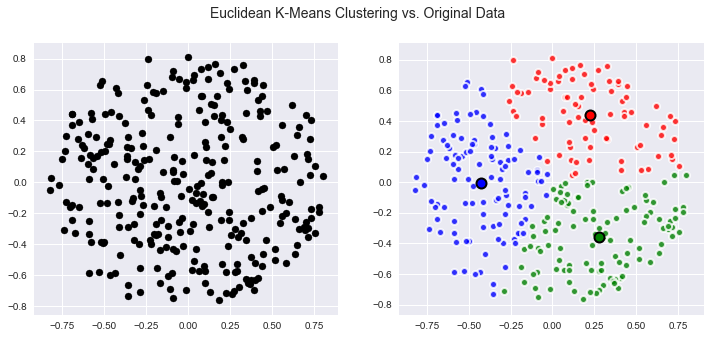

Cluster variance:  1.6121318230531025
Inertia (euclidean dist):  37.50283633898159


In [285]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3)
labels = kmeans.fit_predict(data)
centroids = kmeans.cluster_centers_
plot_poincare(data, labels, centroids, 3, euclidean=True)
print('Cluster variance: ', cluster_var(data, centroids))
print('Inertia (euclidean dist): ', kmeans.inertia_)

## Social network/graph data

###  zachary karate

In [327]:
karate_df = pd.read_csv('../data/ucidata-zachary/out.tsv', delimiter=' ')
u = karate_df.iloc[:, 0]
v = karate_df.iloc[:, 1]
n = len(np.unique(karate_df))
num_edges = len(u)
adj_matrix = np.zeros((n, n))
for i in range(num_edges):
    adj_matrix[u[i]-1][v[i]-1] = 1

In [370]:
from gensim.models.poincare import PoincareModel, PoincareKeyedVectors, PoincareRelations
import logging
logging.basicConfig(level=logging.INFO)
relations = PoincareRelations(file_path='../data/ucidata-zachary/out.tsv', delimiter=' ')
model = PoincareModel(train_data=relations)

size=2
burn_in=10
workers=1 # multi-threaded version wasn't implemented yet
negative=10
epochs=100
print_every=500
batch_size=10
model = PoincareModel(train_data=relations, size=size, burn_in=burn_in, workers=workers, negative=negative)
model.train(epochs=epochs, print_every=print_every,batch_size=batch_size)

INFO:gensim.models.poincare:loading relations from train data..
INFO:gensim.models.poincare:loaded 78 relations from train data, 34 nodes
INFO:gensim.models.poincare:loading relations from train data..
INFO:gensim.models.poincare:loaded 78 relations from train data, 34 nodes
INFO:gensim.models.poincare:training model of size 2 with 1 workers on 78 relations for 100 epochs and 10 burn-in epochs, using lr=0.10000 burn-in lr=0.01000 negative=10
INFO:gensim.models.poincare:starting burn-in (10 epochs)----------------------------------------
INFO:gensim.models.poincare:burn-in finished
INFO:gensim.models.poincare:starting training (100 epochs)----------------------------------------
INFO:gensim.models.poincare:training finished


In [371]:
# Saves only the vectors from the PoincareModel instance, in the commonly used word2vec format
import os
model.kv.save_word2vec_format(os.path.join('models','karate_vectors'))
PoincareKeyedVectors.load_word2vec_format(os.path.join('models','karate_vectors'))

emb = pd.read_table('models/karate_vectors', delimiter=' ')
emb = emb.reset_index()
emb.columns = ['node', 'x', 'y']

x = emb.loc[:, 'x'].values
y = emb.loc[:, 'y'].values
emb_data = np.hstack((x.reshape(-1,1), y.reshape(-1,1)))
emb_data.shape

INFO:gensim.models.utils_any2vec:storing 34x2 projection weights into models\karate_vectors
INFO:gensim.models.utils_any2vec:loading projection weights from models\karate_vectors
INFO:gensim.models.utils_any2vec:loaded (34, 2) matrix from models\karate_vectors


(34, 2)

Cluster variance:  1.4920416658676139
Inertia (poincaré dist):  48.14366925536521
Inertia (euclidean dist):  4.566710779111631


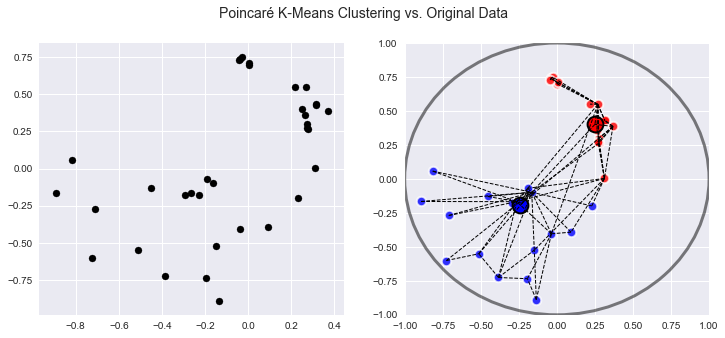

In [372]:
data = emb_data
pkmeans = PoincareKMeans(n_clusters=2)
y = pkmeans.fit_predict(data, max_epochs=15)
centroids = pkmeans.centroids
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.scatter(data[:, 0], data[:, 1], c='black')
plt.subplot(122)
plt.xlim([-1.0,1.0])
plt.ylim([-1.0,1.0])
colors = ['b', 'r', 'g', 'y', 'm', 'c', 'k', 'w']
n_clusters=2
for i in range(n_clusters):
    plt.scatter(data[(y[:, i] == 1), 0], data[(y[:, i] == 1), 1], c = colors[i],
                alpha=0.8, edgecolors='w', linewidth=2, s=90)
    plt.scatter(centroids[i, 0], centroids[i, 1], s=250, c = colors[i],
                edgecolor='black', linewidth=2);
for i in range(1, len(u)):
    x1 = emb.loc[(emb.node == u[i]), ['x', 'y']].values[0]
    x2 = emb.loc[(emb.node == v[i]), ['x', 'y']].values[0]
    _ = plt.plot([x1[0], x2[0]], [x1[1], x2[1]], '--', c='black', linewidth=1)
ax = plt.gca()
circ = plt.Circle((0, 0), radius=1, edgecolor='black', facecolor='None', linewidth=3, alpha=0.5)
ax.add_patch(circ)
plt.suptitle('Poincaré K-Means Clustering vs. Original Data', size=14);
print('Cluster variance: ', pkmeans.variances)
print('Inertia (poincaré dist): ', pkmeans.inertia_)
print('Inertia (euclidean dist): ', euclidean_inertia(data, centroids))
plt.show();

Cluster variance:  1.4920416658676139
Inertia (poincaré dist):  48.14366925536521
Inertia (euclidean dist):  4.566710779111631


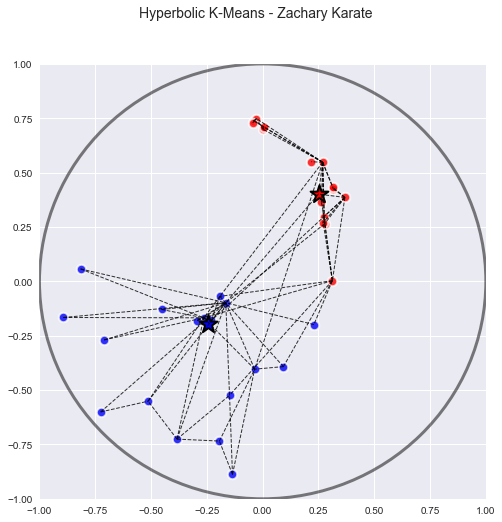

In [377]:
plt.figure(figsize=(8,8))
plt.xlim([-1.0,1.0])
plt.ylim([-1.0,1.0])
colors = ['b', 'r', 'g', 'y', 'm', 'c', 'k', 'w']
n_clusters=2
for i in range(n_clusters):
    plt.scatter(data[(y[:, i] == 1), 0], data[(y[:, i] == 1), 1], c = colors[i],
                alpha=0.8, edgecolors='w', linewidth=2, s=90)
    plt.scatter(centroids[i, 0], centroids[i, 1], s=350, c = colors[i],
                edgecolor='black', linewidth=2, marker='*');
for i in range(1, len(u)):
    x1 = emb.loc[(emb.node == u[i]), ['x', 'y']].values[0]
    x2 = emb.loc[(emb.node == v[i]), ['x', 'y']].values[0]
    _ = plt.plot([x1[0], x2[0]], [x1[1], x2[1]], '--', c='black', linewidth=1, alpha=0.8)
ax = plt.gca()
circ = plt.Circle((0, 0), radius=1, edgecolor='black', facecolor='None', linewidth=3, alpha=0.5)
ax.add_patch(circ)
plt.suptitle('Hyperbolic K-Means - Zachary Karate', size=14);
print('Cluster variance: ', pkmeans.variances)
print('Inertia (poincaré dist): ', pkmeans.inertia_)
print('Inertia (euclidean dist): ', euclidean_inertia(data, centroids))
plt.show();

### NCAA football teams

In [578]:
import networkx as nx
G = nx.read_gml('football.gml', label='id')
football_df = pd.DataFrame(np.array(G.nodes()))

u = np.array([x[0] for x in list(G.edges())])
v = np.array([x[1] for x in list(G.edges())])

football_df = pd.DataFrame(u, columns=['u'])
football_df['v'] = v
football_df.to_csv('football_relations.csv', index=False)

In [580]:
n = len(np.unique(football_df))
num_edges = len(u)
relations = PoincareRelations(file_path='football_relations.csv', delimiter=',')

size=2
burn_in=20
workers=1 # multi-threaded version wasn't implemented yet
negative=15
epochs=100
print_every=1000
batch_size=10

model = PoincareModel(train_data=relations, size=size, burn_in=burn_in, workers=workers, negative=negative)
model.train(epochs=epochs, print_every=print_every,batch_size=batch_size)
model.kv.save_word2vec_format(os.path.join('models','football_vectors'))
PoincareKeyedVectors.load_word2vec_format(os.path.join('models','football_vectors'))

INFO:gensim.models.poincare:loading relations from train data..
INFO:gensim.models.poincare:loaded 614 relations from train data, 117 nodes
INFO:gensim.models.poincare:training model of size 2 with 1 workers on 614 relations for 100 epochs and 20 burn-in epochs, using lr=0.10000 burn-in lr=0.01000 negative=15
INFO:gensim.models.poincare:starting burn-in (20 epochs)----------------------------------------
INFO:gensim.models.poincare:burn-in finished
INFO:gensim.models.poincare:starting training (100 epochs)----------------------------------------
INFO:gensim.models.poincare:training finished
INFO:gensim.models.utils_any2vec:storing 117x2 projection weights into models\football_vectors
INFO:gensim.models.utils_any2vec:loading projection weights from models\football_vectors
INFO:gensim.models.utils_any2vec:loaded (117, 2) matrix from models\football_vectors


In [584]:
emb = pd.read_csv('models/football_vectors', delimiter=' ')
emb.head()
emb.shape

emb = emb.reset_index()
emb.columns = ['node', 'x', 'y']
emb = emb.iloc[:-2, :]

x = emb.loc[:, 'x'].values
y = emb.loc[:, 'y'].values
emb_data = np.hstack((x.reshape(-1,1), y.reshape(-1,1)))
emb_data.shape

,117,2
0,0.415741,0.867830
1,-0.746296,0.541134
104,0.289917,0.482765
2,0.634670,-0.704274
3,0.257119,-0.897774


(117, 2)

(115, 2)

Cluster variance:  3.2589132138791217
Inertia (poincaré dist):  79.73272076710663
Inertia (euclidean dist):  2.8486559642972717


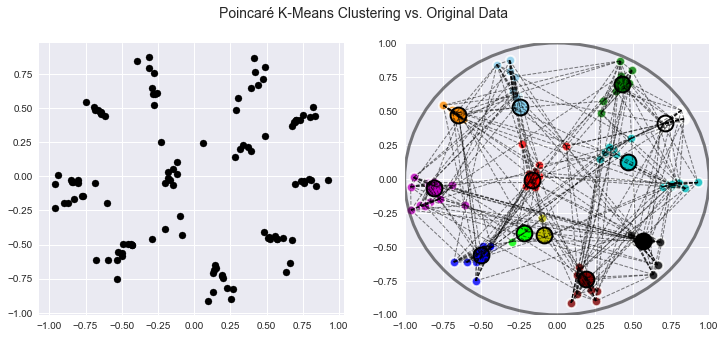

In [587]:
data = emb_data
n_clusters=12
pkmeans = PoincareKMeans(n_clusters=n_clusters)
y = pkmeans.fit_predict(data, max_epochs=15)
centroids = pkmeans.centroids
plt.figure(figsize=(12,5))

plt.subplot(121)
plt.scatter(data[:, 0], data[:, 1], c='black')
plt.subplot(122)
plt.xlim([-1.0,1.0])
plt.ylim([-1.0,1.0])
colors = ['b', 'r', 'g', 'y', 'm', 'c', 'k', 'w', 'lime', 'skyblue', 'maroon', 'darkorange']
for i in range(n_clusters):
    plt.scatter(data[(y[:, i] == 1), 0], data[(y[:, i] == 1), 1], c = colors[i],
                alpha=0.8, edgecolors='w', linewidth=2, s=90)
    plt.scatter(centroids[i, 0], centroids[i, 1], s=250, c = colors[i],
                edgecolor='black', linewidth=2);
for i in range(len(u)-1):
    x1 = emb.loc[(emb.node == str(u[i])), ['x', 'y']].values[0]
    x2 = emb.loc[(emb.node == str(v[i])), ['x', 'y']].values[0]
    _ = plt.plot([x1[0], x2[0]], [x1[1], x2[1]], '--', c='black', linewidth=1, alpha=0.5)
ax = plt.gca()
circ = plt.Circle((0, 0), radius=1, edgecolor='black', facecolor='None', linewidth=3, alpha=0.5)
ax.add_patch(circ)
plt.suptitle('Poincaré K-Means Clustering vs. Original Data', size=14);
print('Cluster variance: ', pkmeans.variances)
print('Inertia (poincaré dist): ', pkmeans.inertia_)
print('Inertia (euclidean dist): ', euclidean_inertia(data, centroids))
plt.show();

In [588]:
teams = []
for i in range(emb.shape[0]):
    teams.append(G.node[i]['label'])
labels = []
for i in range(emb.shape[0]):
    labels.append(G.node[i]['value'])
teams = np.array(teams)
labels = np.array(labels)

football_dict = {}
label_dict = {}
for i in range(emb.shape[0]):
    label_dict[teams[i]] = np.argwhere(y[i] == 1)[0][0]

for i in range(emb.shape[0]):
    football_dict[teams[i]] = emb_data[i]

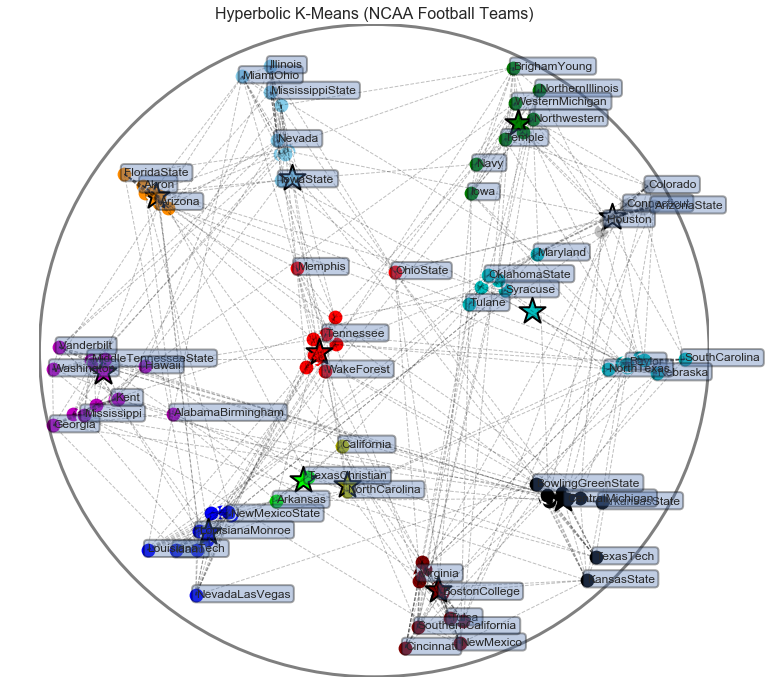

In [589]:
fig = plt.figure(figsize=(12,12))
plt.xlim([-1.0,1.0])
plt.ylim([-1.0,1.0])
plt.grid('off')
plt.axis('off')
colors = ['b', 'r', 'g', 'y', 'm', 'c', 'k', 'silver', 'lime', 'skyblue', 'maroon', 'darkorange']
n_clusters=12
for i in range(n_clusters):
    plt.scatter(data[(y[:, i] == 1), 0], data[(y[:, i] == 1), 1], c = colors[i],
                edgecolors='w', linewidth=2, s=250)
    plt.scatter(centroids[i, 0], centroids[i, 1], s=750, c = colors[i],
                edgecolor='black', linewidth=2, marker='*');
for i in range(1, len(u)):
    x1 = emb.loc[(emb.node == str(u[i])), ['x', 'y']].values[0]
    x2 = emb.loc[(emb.node == str(v[i])), ['x', 'y']].values[0]
    _ = plt.plot([x1[0], x2[0]], [x1[1], x2[1]], '--', c='black', linewidth=1, alpha=0.25)
ax = plt.gca()
circ = plt.Circle((0, 0), radius=1, edgecolor='black', facecolor='None', linewidth=3, alpha=0.5)
ax.add_patch(circ)

label_frac = 0.001
plot_frac = 1
embed_vals = np.array(list(football_dict.values()))
keys = list(football_dict.keys())
min_dist_2 = label_frac * max(embed_vals.max(axis=0) - embed_vals.min(axis=0)) ** 2
labeled_vals = np.array([2*embed_vals.max(axis=0)])
n = int(plot_frac*len(embed_vals))
for i in np.random.permutation(len(embed_vals))[:n]:
    _ = ax.scatter(embed_vals[i][0], embed_vals[i][1], s=40, c=colors[label_dict[keys[i]]])
    if np.min(dist_squared(embed_vals[i], labeled_vals, axis=1)) < min_dist_2:
        continue
    else:
        props = dict(boxstyle='round', lw=2, edgecolor='black', alpha=0.35)
        _ = ax.text(embed_vals[i][0], embed_vals[i][1]+0.02, s=keys[i].split('.')[0],
                    size=10, fontsize=12, verticalalignment='top', bbox=props)
        labeled_vals = np.vstack((labeled_vals, embed_vals[i]))
plt.title('Hyperbolic K-Means (NCAA Football Teams)', size=16)
#plt.savefig('ncaa_kmeans.png')
plt.show();

### Scientific Collaboration Network

In [641]:
import networkx as nx
G = nx.read_gml('astro-ph.gml', label='id')

u = np.array([x[0] for x in list(G.edges())[::0]])
v = np.array([x[1] for x in list(G.edges())[::20]])

science_df = pd.DataFrame(u, columns=['u'])
science_df['v'] = v
science_df.to_csv('science_relations.csv', index=False)

In [643]:
n = len(np.unique(science_df))
num_edges = len(u)
relations = PoincareRelations(file_path='science_relations.csv', delimiter=',')

size=2
burn_in=10
workers=1 # multi-threaded version wasn't implemented yet
negative=15
epochs=100
print_every=500
batch_size=10

model = PoincareModel(train_data=relations, size=size, burn_in=burn_in, workers=workers, negative=negative)
model.train(epochs=epochs, print_every=print_every,batch_size=batch_size)
model.kv.save_word2vec_format(os.path.join('models','science_vectors'))
PoincareKeyedVectors.load_word2vec_format(os.path.join('models','science_vectors'))

INFO:gensim.models.poincare:loading relations from train data..
INFO:gensim.models.poincare:loaded 1214 relations from train data, 2159 nodes
INFO:gensim.models.poincare:training model of size 2 with 1 workers on 1214 relations for 100 epochs and 10 burn-in epochs, using lr=0.10000 burn-in lr=0.01000 negative=15
INFO:gensim.models.poincare:starting burn-in (10 epochs)----------------------------------------
INFO:gensim.models.poincare:burn-in finished
INFO:gensim.models.poincare:starting training (100 epochs)----------------------------------------
INFO:gensim.models.poincare:training finished
INFO:gensim.models.utils_any2vec:storing 2159x2 projection weights into models\science_vectors
INFO:gensim.models.utils_any2vec:loading projection weights from models\science_vectors
INFO:gensim.models.utils_any2vec:loaded (2159, 2) matrix from models\science_vectors


In [644]:
emb = pd.read_csv('models/science_vectors', delimiter=' ')
emb.shape
emb = emb.reset_index()
emb.columns = ['node', 'x', 'y']
x = emb.loc[:, 'x'].values
y = emb.loc[:, 'y'].values
emb_data = np.hstack((x.reshape(-1,1), y.reshape(-1,1)))
emb_data.shape
emb.head()

(2159, 2)

(2159, 2)

,node,x,y
0,1231,0.461661,0.857885
1,912,0.947295,0.270148
2,6529,0.493509,-0.840892
3,5502,-0.039727,-0.975446
4,6200,0.848798,0.476015


IndexError: index 1213 is out of bounds for axis 0 with size 1213

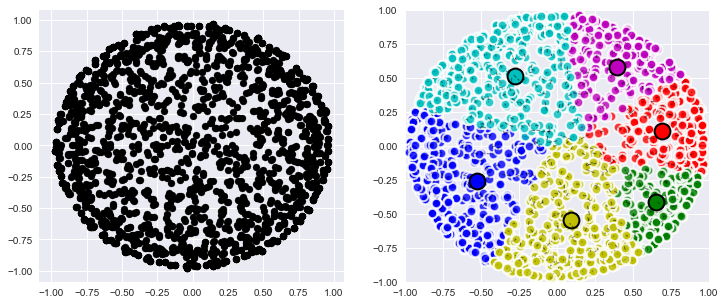

In [645]:
data = emb_data
n_clusters=6
pkmeans = PoincareKMeans(n_clusters=n_clusters)
y = pkmeans.fit_predict(data, max_epochs=10)
centroids = pkmeans.centroids
plt.figure(figsize=(12,5))

plt.subplot(121)
plt.scatter(data[:, 0], data[:, 1], c='black')
plt.subplot(122)
plt.xlim([-1.0,1.0])
plt.ylim([-1.0,1.0])
colors = ['b', 'r', 'g', 'y', 'm', 'c', 'k', 'w', 'lime', 'skyblue', 'maroon', 'darkorange']
for i in range(n_clusters):
    plt.scatter(data[(y[:, i] == 1), 0], data[(y[:, i] == 1), 1], c = colors[i],
                alpha=0.8, edgecolors='w', linewidth=2, s=90)
    plt.scatter(centroids[i, 0], centroids[i, 1], s=250, c = colors[i],
                edgecolor='black', linewidth=2);
for i in range(emb.shape[0]):
    x1 = emb.loc[(emb.node == str(u[i])), ['x', 'y']].values[0]
    x2 = emb.loc[(emb.node == str(v[i])), ['x', 'y']].values[0]
    _ = plt.plot([x1[0], x2[0]], [x1[1], x2[1]], '--', c='black', linewidth=1, alpha=0.5)
ax = plt.gca()
circ = plt.Circle((0, 0), radius=1, edgecolor='black', facecolor='None', linewidth=3, alpha=0.5)
ax.add_patch(circ)
plt.suptitle('Poincaré K-Means Clustering vs. Original Data', size=14);
print('Cluster variance: ', pkmeans.variances)
print('Inertia (poincaré dist): ', pkmeans.inertia_)
print('Inertia (euclidean dist): ', euclidean_inertia(data, centroids))
plt.show();

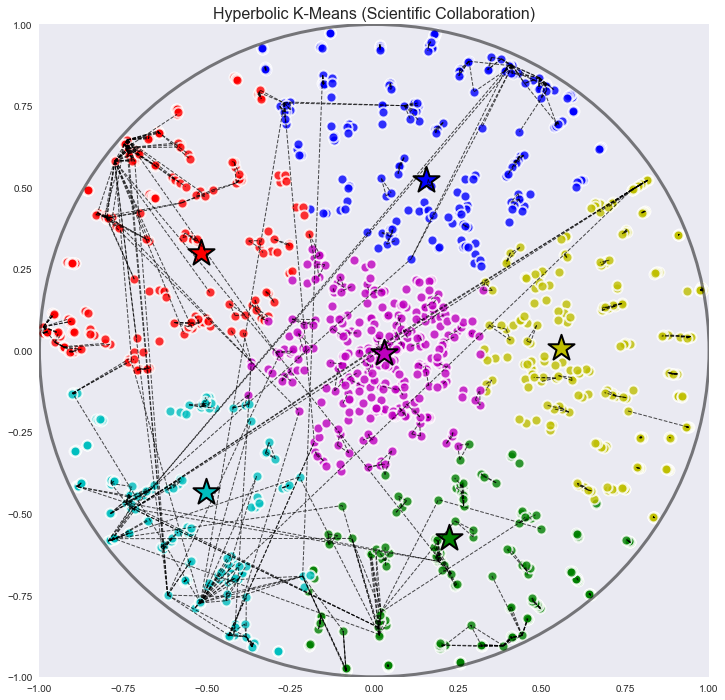

In [627]:
fig = plt.figure(figsize=(12,12))
plt.xlim([-1.0,1.0])
plt.ylim([-1.0,1.0])
plt.grid('off')
colors = ['b', 'r', 'g', 'y', 'm', 'c', 'k', 'silver', 'lime', 'skyblue', 'maroon', 'darkorange']
n_clusters=6
for i in range(n_clusters):
    plt.scatter(data[(y[:, i] == 1), 0], data[(y[:, i] == 1), 1], c = colors[i],
                edgecolors='w', linewidth=2, s=100, alpha=0.8)
    plt.scatter(centroids[i, 0], centroids[i, 1], s=750, c = colors[i],
                edgecolor='black', linewidth=2, marker='*');
for i in range(emb.shape[0]):
    x1 = emb.loc[(emb.node == str(u[i])), ['x', 'y']].values[0]
    x2 = emb.loc[(emb.node == str(v[i])), ['x', 'y']].values[0]
    _ = plt.plot([x1[0], x2[0]], [x1[1], x2[1]], '--', c='black', linewidth=1, alpha=0.7)
ax = plt.gca()
circ = plt.Circle((0, 0), radius=1, edgecolor='black', facecolor='None', linewidth=3, alpha=0.5)
ax.add_patch(circ)
plt.title('Hyperbolic K-Means (Scientific Collaboration)', size=16)
#plt.savefig('ncaa_kmeans.png')
plt.show();

## WordNET Mammals Subtree

### Train the poincaré embedding with gensim

In [240]:
from gensim.models.poincare import PoincareModel, PoincareKeyedVectors, PoincareRelations
import logging
logging.basicConfig(level=logging.INFO)
relations = PoincareRelations(file_path='wordnet_mammal_hypernyms.tsv', delimiter='\t')
model = PoincareModel(train_data=relations)

size=2
burn_in=0
workers=1 # multi-threaded version wasn't implemented yet
negative=15
epochs=100
print_every=500
batch_size=10
model = PoincareModel(train_data=relations, size=size, burn_in=burn_in, workers=workers, negative=negative)
model.train(epochs=epochs, print_every=print_every,batch_size=batch_size)

INFO:gensim.models.poincare:loading relations from train data..
INFO:gensim.models.poincare:loaded 7724 relations from train data, 1182 nodes
INFO:gensim.models.poincare:loading relations from train data..
INFO:gensim.models.poincare:loaded 7724 relations from train data, 1182 nodes
INFO:gensim.models.poincare:training model of size 2 with 1 workers on 7724 relations for 100 epochs and 0 burn-in epochs, using lr=0.10000 burn-in lr=0.01000 negative=15
INFO:gensim.models.poincare:starting training (100 epochs)----------------------------------------
INFO:gensim.models.poincare:training on epoch 1, examples #4990-#5000, loss: 27.31
INFO:gensim.models.poincare:time taken for 5000 examples: 1.70 s, 2937.94 examples / s
INFO:gensim.models.poincare:training on epoch 2, examples #4990-#5000, loss: 25.89
INFO:gensim.models.poincare:time taken for 5000 examples: 1.62 s, 3088.89 examples / s
INFO:gensim.models.poincare:training on epoch 3, examples #4990-#5000, loss: 24.47
INFO:gensim.models.poin

INFO:gensim.models.poincare:training on epoch 46, examples #4990-#5000, loss: 11.85
INFO:gensim.models.poincare:time taken for 5000 examples: 1.59 s, 3139.22 examples / s
INFO:gensim.models.poincare:training on epoch 47, examples #4990-#5000, loss: 11.46
INFO:gensim.models.poincare:time taken for 5000 examples: 1.69 s, 2957.68 examples / s
INFO:gensim.models.poincare:training on epoch 48, examples #4990-#5000, loss: 11.44
INFO:gensim.models.poincare:time taken for 5000 examples: 1.62 s, 3090.93 examples / s
INFO:gensim.models.poincare:training on epoch 49, examples #4990-#5000, loss: 11.26
INFO:gensim.models.poincare:time taken for 5000 examples: 1.62 s, 3081.36 examples / s
INFO:gensim.models.poincare:training on epoch 50, examples #4990-#5000, loss: 11.21
INFO:gensim.models.poincare:time taken for 5000 examples: 1.71 s, 2923.30 examples / s
INFO:gensim.models.poincare:training on epoch 51, examples #4990-#5000, loss: 11.36
INFO:gensim.models.poincare:time taken for 5000 examples: 1.6

INFO:gensim.models.poincare:time taken for 5000 examples: 1.68 s, 2984.21 examples / s
INFO:gensim.models.poincare:training on epoch 95, examples #4990-#5000, loss: 7.90
INFO:gensim.models.poincare:time taken for 5000 examples: 1.57 s, 3175.07 examples / s
INFO:gensim.models.poincare:training on epoch 96, examples #4990-#5000, loss: 7.85
INFO:gensim.models.poincare:time taken for 5000 examples: 1.64 s, 3043.88 examples / s
INFO:gensim.models.poincare:training on epoch 97, examples #4990-#5000, loss: 7.94
INFO:gensim.models.poincare:time taken for 5000 examples: 1.61 s, 3111.96 examples / s
INFO:gensim.models.poincare:training on epoch 98, examples #4990-#5000, loss: 7.67
INFO:gensim.models.poincare:time taken for 5000 examples: 1.63 s, 3075.60 examples / s
INFO:gensim.models.poincare:training on epoch 99, examples #4990-#5000, loss: 7.71
INFO:gensim.models.poincare:time taken for 5000 examples: 1.69 s, 2954.25 examples / s
INFO:gensim.models.poincare:training on epoch 100, examples #49

In [265]:
# Saves only the vectors from the PoincareModel instance, in the commonly used word2vec format
model.kv.save_word2vec_format(os.path.join('models','test_vectors'))
PoincareKeyedVectors.load_word2vec_format(os.path.join('models','test_vectors'))
emb = pd.read_csv('models/test_vectors.csv', delimiter=' ')
emb = emb.reset_index()
x = emb.loc[:, '1182'].values
y = emb.loc[:, '2'].values
emb_data = np.hstack((x.reshape(-1,1), y.reshape(-1,1)))
emb_data.shape

INFO:gensim.models.utils_any2vec:storing 1182x2 projection weights into models\test_vectors
INFO:gensim.models.utils_any2vec:loading projection weights from models\test_vectors
INFO:gensim.models.utils_any2vec:loaded (1182, 2) matrix from models\test_vectors


(1182, 2)

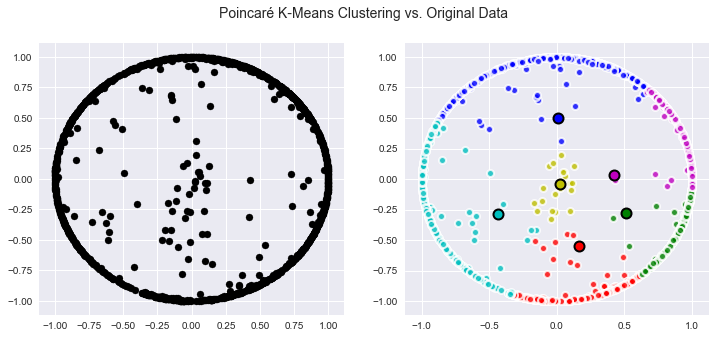

Cluster variance:  7.808910917735112
Inertia (poincaré dist):  55895.802105377355
Inertia (euclidean dist):  373.3436876508831


In [245]:
data = emb_data
pkmeans = PoincareKMeans(n_clusters=6)
y = pkmeans.fit_predict(data, max_epochs=15)
centroids = pkmeans.centroids
plot_poincare(data, y, centroids, n_clusters=6)
print('Cluster variance: ', pkmeans.variances)
print('Inertia (poincaré dist): ', pkmeans.inertia_)
print('Inertia (euclidean dist): ', euclidean_inertia(data, centroids))

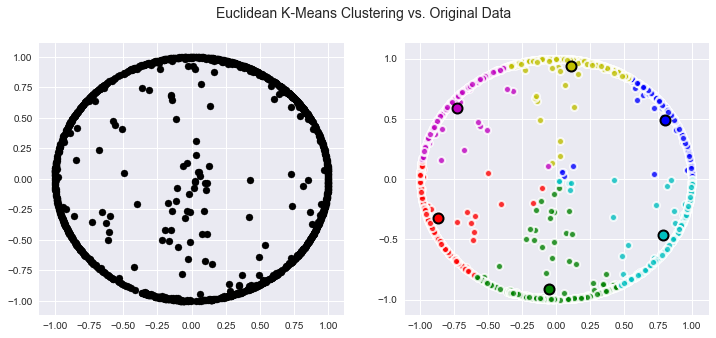

Cluster variance:  9.522594937646042
Inertia (euclidean dist):  109.65701902080615


In [247]:
kmeans_clf = KMeans(n_clusters=6)
y = kmeans_clf.fit_predict(data)
centroids = kmeans_clf.cluster_centers_
plot_poincare(data, y, centroids, n_clusters=6, euclidean=True)
print('Cluster variance: ', cluster_var(data, centroids))
print('Inertia (euclidean dist): ', kmeans_clf.inertia_)

In [248]:
mammal_dict = {}
mammals = emb['index'].values
label_dict = {}
for i in range(emb.shape[0]):
    label_dict[mammals[i]] = y[i]

for i in range(emb.shape[0]):
    mammal_dict[mammals[i]] = emb_data[i]

def dist_squared(x, y, axis=None):
    return np.sum((x - y)**2, axis=axis)

In [260]:
def plot_embedding(embedding_dict, label_frac=0.001, plot_frac=0.6, title=None, save_fig=False):
    colors = ['b', 'g', 'r', 'y', 'm', 'c', 'k', 'w']
    fig = plt.figure(figsize=(8,8))
    plt.grid('off')
    plt.xlim([-1.2,1.2])
    plt.ylim([-1.2,1.2])
    plt.axis('off')
    ax = plt.gca()
    embed_vals = np.array(list(embedding_dict.values()))
    #plt.xlim([embed_vals.min(0)[0],embed_vals.max(0)[0]])
    #plt.ylim([embed_vals.min(0)[1],embed_vals.max(0)[1]])
    keys = list(embedding_dict.keys())
    min_dist_2 = label_frac * max(embed_vals.max(axis=0) - embed_vals.min(axis=0)) ** 2
    labeled_vals = np.array([2*embed_vals.max(axis=0)])
    groups = [keys[i] for i in np.argsort(np.linalg.norm(embed_vals, axis=1))][:10]
    groups.insert(0, 'mammal.n.01')
    for key in groups:
        if np.min(dist_squared(embedding_dict[key], labeled_vals, axis=1)) < min_dist_2:
            continue
        else:
            _ = ax.scatter(embedding_dict[key][0], embedding_dict[key][1], s=40, c=colors[label_dict[key]])
            props = dict(boxstyle='round', lw=2, edgecolor='black', alpha=0.5)
            _ = ax.text(embedding_dict[key][0], embedding_dict[key][1]+0.01, s=key.split('.')[0], 
                        size=8, fontsize=10, verticalalignment='top', bbox=props)
            labeled_vals = np.vstack((labeled_vals, embedding_dict[key]))
    n = int(plot_frac*len(embed_vals))
    for i in np.random.permutation(len(embed_vals))[:n]:
        _ = ax.scatter(embed_vals[i][0], embed_vals[i][1], s=40, c=colors[label_dict[keys[i]]])
        if np.min(dist_squared(embed_vals[i], labeled_vals, axis=1)) < min_dist_2:
            continue
        else:
            _ = ax.text(embed_vals[i][0], embed_vals[i][1]+0.02, s=keys[i].split('.')[0], 
                        size=6, fontsize=8, verticalalignment='top', bbox=props)
            labeled_vals = np.vstack((labeled_vals, embed_vals[i]))
    if title != None:
        plt.title(title, size=16)
    if save_fig:
        plt.savefig('images/poincare_mammals_sample.png')
    print(labeled_vals.shape)

(80, 2)


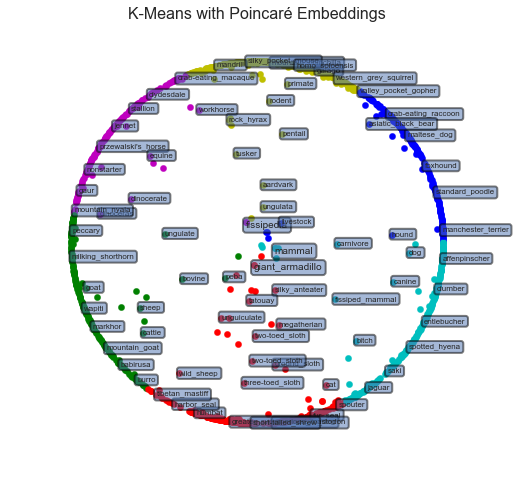

In [264]:
plot_embedding(mammal_dict, plot_frac=1, label_frac=0.003,
               title='K-Means with Poincaré Embeddings')

# Supervised Learning Examples

In [ ]:
from sklearn import metrics
labels_true = labels
labels_pred = pkmeans.labels
#metrics.adjusted_mutual_info_score(labels_true, labels_pred) 
#metrics.mutual_info_score(labels_true, labels_pred)
print('Poincare mutual info score: ', metrics.normalized_mutual_info_score(labels_true, labels_pred))

from sklearn.cluster import KMeans
kmeans_clf = KMeans(n_clusters=4)
labels_pred = kmeans_clf.fit_predict(data)
#metrics.adjusted_mutual_info_score(labels_true, labels_pred) 
#metrics.mutual_info_score(labels_true, labels_pred)
print('Euclidean mutual info score: ', metrics.normalized_mutual_info_score(labels_true, labels_pred))

## Iris data

In [28]:
iris_emb = pd.read_csv('../data/mds_iris.csv')
iris_emb.head()

,0,1,label
0,-0.447808,-0.739467,0
1,-0.645854,0.024138,0
2,-0.346868,-0.602623,0
3,0.748350,0.497737,0
4,-0.319968,-0.728208,0


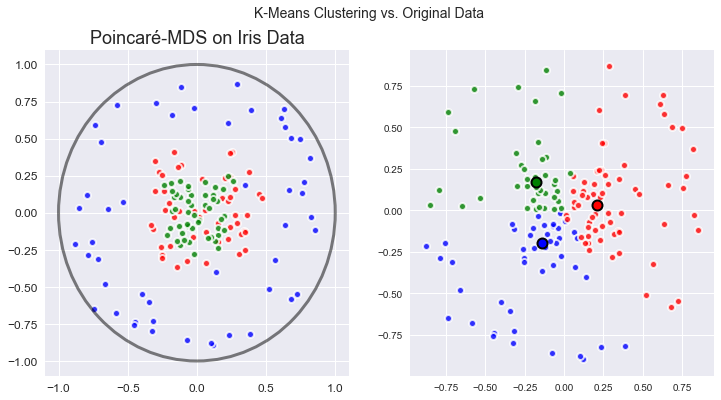

In [141]:
X = iris_emb.loc[:, ['0','1']].values
labels = iris_emb.label.values
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(121)
circ = plt.Circle((0, 0), radius=1, edgecolor='black', facecolor='None', linewidth=3, alpha=0.5)
ax.add_patch(circ)
ax.scatter(X[(labels==0), 0], X[(labels==0), 1], c='blue', alpha=0.8, edgecolors='w', linewidth=2)
ax.scatter(X[(labels==1), 0], X[(labels==1), 1], c='red', alpha=0.8, edgecolors='w', linewidth=2)
ax.scatter(X[(labels==2), 0], X[(labels==2), 1], c='green', alpha=0.8, edgecolors='w', linewidth=2)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_title('Poincaré-MDS on Iris Data', size=18);

plt.subplot(122)
data = X
kmeans = PoincareKMeans(n_clusters=3)
y = kmeans.fit_predict(data, max_epochs=5)
centroids = kmeans.centroids
plt.scatter(data[(y[:, 0] == 1), 0], data[(y[:, 0] == 1), 1], c='blue', alpha=0.8, edgecolors='w', linewidth=2)
plt.scatter(data[(y[:, 1] == 1), 0], data[(y[:, 1] == 1), 1], c='red', alpha=0.8, edgecolors='w', linewidth=2)
plt.scatter(data[(y[:, 2] == 1), 0], data[(y[:, 2] == 1), 1], c='green', alpha=0.8, edgecolors='w', linewidth=2)
plt.scatter(centroids[0, 0], centroids[0, 1], s=100, c='blue', edgecolor='black', linewidth=2)
plt.scatter(centroids[1, 0], centroids[1, 1], s=100, c='red', edgecolor='black', linewidth=2);
plt.scatter(centroids[2, 0], centroids[2, 1], s=100, c='green', edgecolor='black', linewidth=2);
plt.suptitle('K-Means Clustering vs. Original Data', size=14);

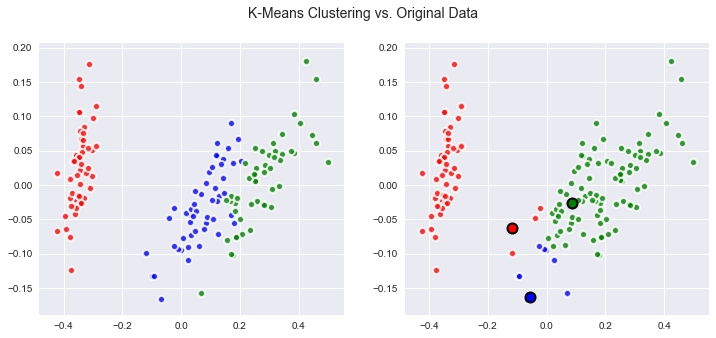

In [139]:
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
iris = load_iris()
iris_data = iris.data
y = iris.target
pca = PCA(n_components=2)
data = pca.fit_transform(iris.data)
data = data / (2*np.max(norm(data, axis=1)))
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.scatter(data[(y == 0), 0], data[(y == 0), 1], c='red', alpha=0.8, edgecolors='w', linewidth=2)
plt.scatter(data[(y == 1), 0], data[(y == 1), 1], c='blue', alpha=0.8, edgecolors='w', linewidth=2)
plt.scatter(data[(y == 2), 0], data[(y == 2), 1], c='green', alpha=0.8, edgecolors='w', linewidth=2)
plt.subplot(122)
kmeans = PoincareKMeans(n_clusters=3)
y = kmeans.fit_predict(data, max_epochs=1)
plt.scatter(data[(y[:, 0] == 1), 0], data[(y[:, 0] == 1), 1], c='red', alpha=0.8, edgecolors='w', linewidth=2)
plt.scatter(data[(y[:, 1] == 1), 0], data[(y[:, 1] == 1), 1], c='blue', alpha=0.8, edgecolors='w', linewidth=2)
plt.scatter(data[(y[:, 2] == 1), 0], data[(y[:, 2] == 1), 1], c='green', alpha=0.8, edgecolors='w', linewidth=2)
centroids = kmeans.centroids
plt.scatter(centroids[0, 0], centroids[0, 1], s=100, c='red', edgecolor='black', linewidth=2)
plt.scatter(centroids[1, 0], centroids[1, 1], s=100, c='blue', edgecolor='black', linewidth=2);
plt.scatter(centroids[2, 0], centroids[2, 1], s=100, c='green', edgecolor='black', linewidth=2);
plt.suptitle('K-Means Clustering vs. Original Data', size=14);

centroids;

In [79]:
from IPython.core.display import HTML

def css_styling():
    styles = open("../custom_style.css", "r").read()
    return HTML(styles)
css_styling()

FileNotFoundError: [Errno 2] No such file or directory: 'hyperbolic-learning/custom_style.css'

## References
---

[1]. Learning graph-structured data using Poincaré embeddings and Riemannian K-means algorithms. Hatem Hajri, Hadi Zaatiti, Georges Hebrail. https://arxiv.org/abs/1907.01662.<br>
[2]. Begelfor, Evgeni and Michael Werman. “The World is not always Flat or Learning Curved Manifolds.” (2005).<br>
[3]. Wilson, Benjamin R. and Matthias Leimeister. “Gradient descent in hyperbolic space.” (2018).